In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

from importlib import reload
from neuropacks import PVC11
from noise_correlations import analysis, plot, utils

%matplotlib inline

In [16]:
base_path = '/Volumes/pss'

In [17]:
path1 = os.path.join(base_path, 'data/pvc11/data/spikes_gratings/data_monkey1_gratings.mat')
path2 = os.path.join(base_path, 'data/pvc11/data/spikes_gratings/data_monkey2_gratings.mat')
path3 = os.path.join(base_path, 'data/pvc11/data/spikes_gratings/data_monkey3_gratings.mat')
paths = [path1, path2, path3]

In [3]:
pvc1 = PVC11(path1)
pvc2 = PVC11(path2)
pvc3 = PVC11(path3)
pvcs = [pvc1, pvc2, pvc3]

In [4]:
Xs = [pvc.get_response_matrix(transform=None) for pvc in pvcs]
stimuli = pvc1.get_design_matrix(form='angle')
n_units = [X.shape[1] for X in Xs]
n_samples = [X.shape[0] for X in Xs]
n_datasets = len(Xs)

In [5]:
peak_responses = [utils.get_peak_response(X, stimuli)
                  for X in Xs]
modulation_fractions = [utils.get_tuning_modulation_fraction(X, stimuli)
                        for X in Xs]
selectivity_indices = [utils.get_selectivity_index(X, stimuli, circular=360)
                       for X in Xs]

# Characterizing response distributions

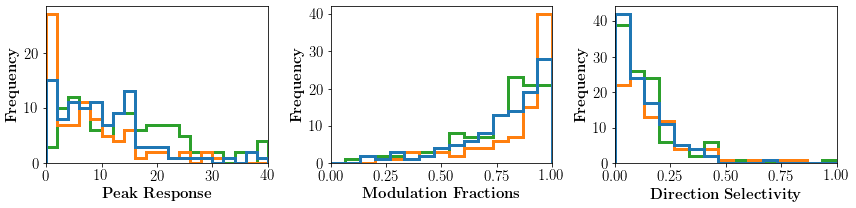

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

axes[0].hist(
    peak_responses,
    histtype='step',
    bins=np.linspace(0, 40, 21),
    linewidth=3)
axes[1].hist(
    modulation_fractions,
    histtype='step',
    bins=np.linspace(0, 1, 16),
    linewidth=3)
axes[2].hist(
    selectivity_indices,
    histtype='step',
    bins=np.linspace(0, 1, 16),
    linewidth=3)

axes[0].set_xlim([0, 40])
axes[1].set_xlim([0, 1])
axes[2].set_xlim([0, 1])
axes[0].set_xlabel(r'\textbf{Peak Response}', fontsize=15)
axes[1].set_xlabel(r'\textbf{Modulation Fractions}', fontsize=15)
axes[2].set_xlabel(r'\textbf{Direction Selectivity}', fontsize=15)

for ax in axes:
    ax.set_ylabel(r'\textbf{Frequency}', fontsize=15)
    ax.tick_params(labelsize=15)
    
plt.tight_layout()

# Tuning Curves

In [7]:
var_to_mean_threshold = 10
responsive_threshold = 2. * 1.28
modulation_frac = 0.60

In [8]:
tuned_units = [
    utils.get_tuned_units(X=X, stimuli=stimuli, aggregator=np.mean,
                          peak_response=responsive_threshold,
                          tuning_criteria='modulation_frac',
                          modulation_frac=modulation_frac,
                          variance_to_mean=var_to_mean_threshold)
    for X in Xs
]

responsive_units = [
    utils.get_responsive_units(X=X, stimuli=stimuli, aggregator=np.mean,
                               peak_response=responsive_threshold,
                               variance_to_mean=var_to_mean_threshold)
    for X in Xs
]

responsive_non_tuned_units = [responsive & ~tuned
                              for responsive, tuned in zip(responsive_units, tuned_units)]
non_responsive_units = [~responsive for responsive in responsive_units]

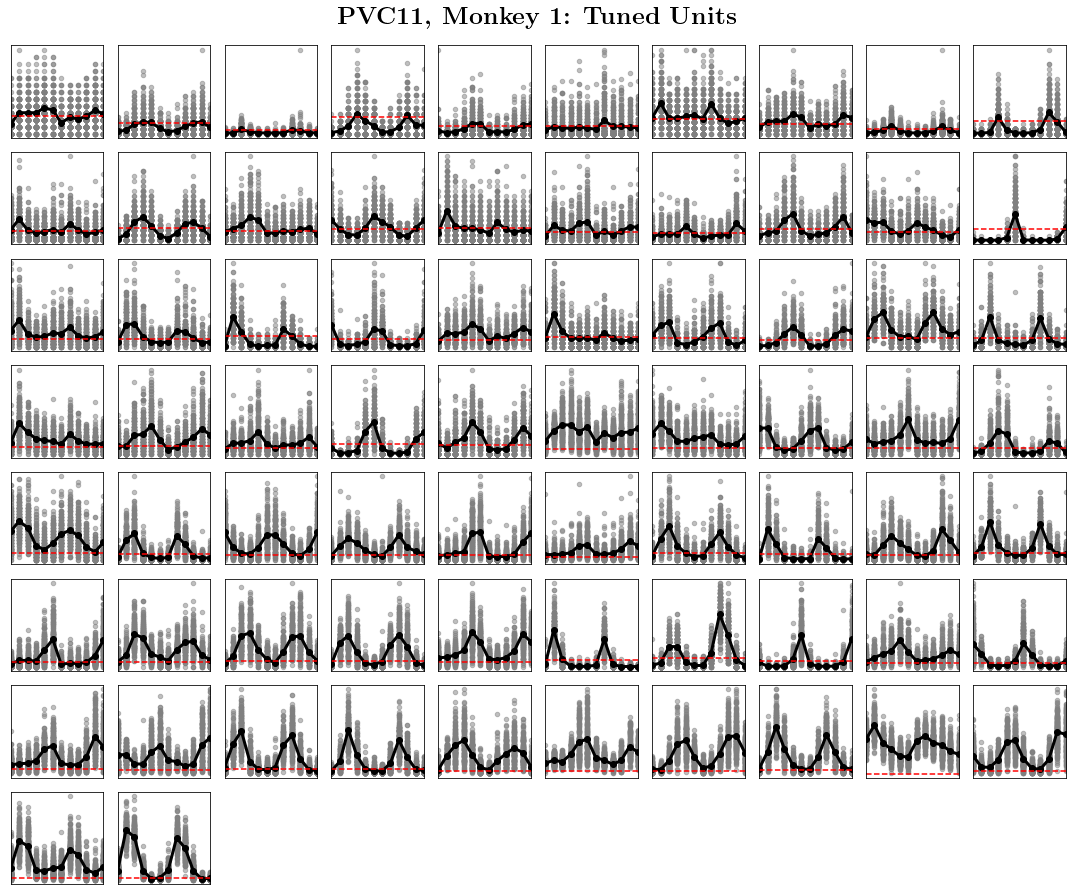

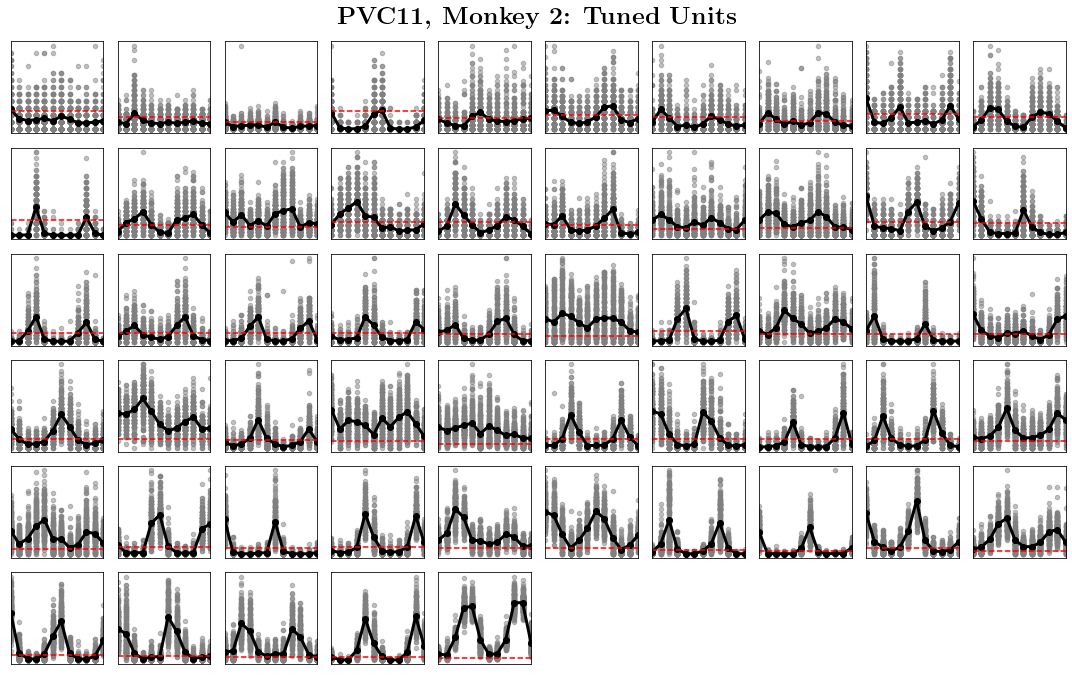

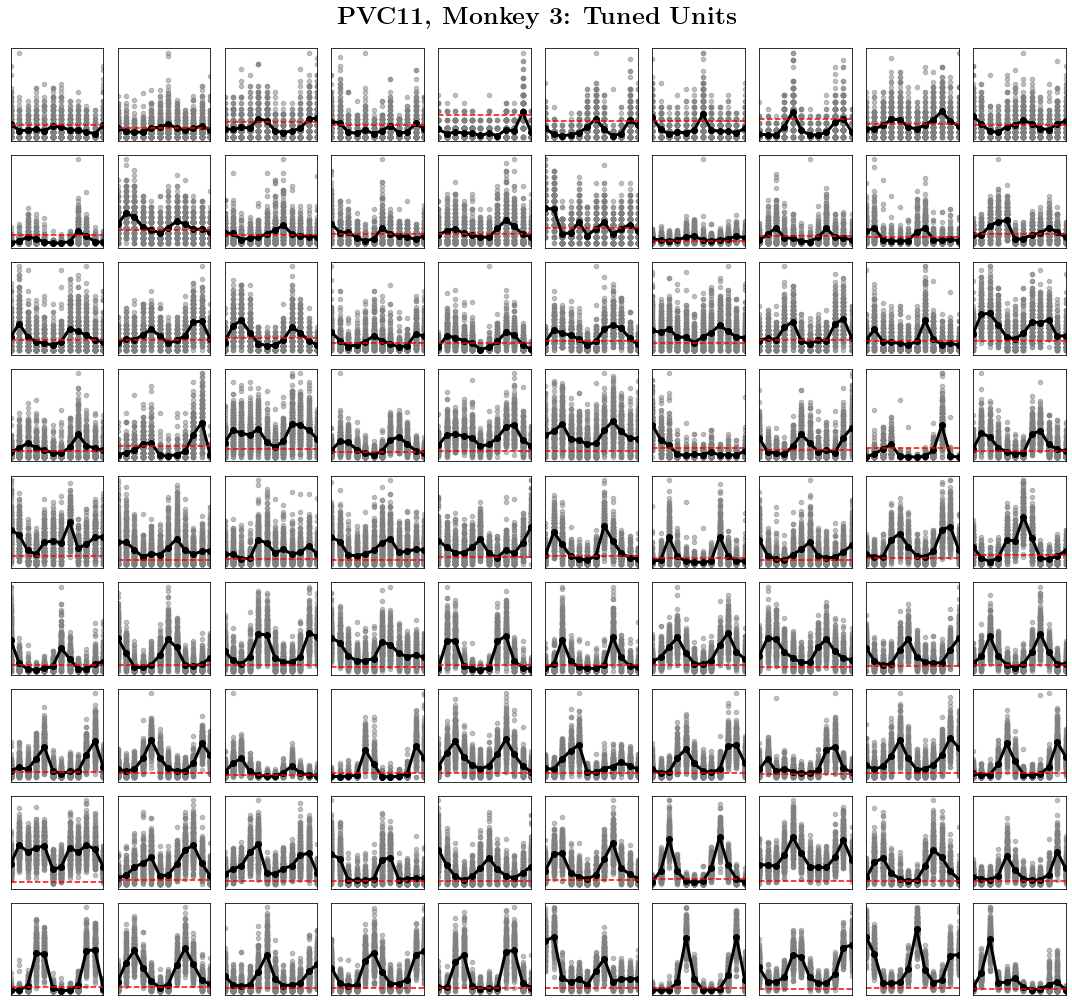

In [9]:
for monkey_idx, (X, units) in enumerate(zip(Xs, tuned_units)):
    fig, axes = plot.plot_tuning_curves(
        X[:, units], stimuli,
        n_cols=10, include_points=True, use_title=False,
        sort='modulation'
    )

    for idx, ax in enumerate(axes.ravel()):
        if idx < units.sum():
            ax.axhline(responsive_threshold, color='r', linestyle='--')

    fig.text(x=0.5, y=1.02, s=r'\textbf{PVC11, Monkey %s: Tuned Units}' % (monkey_idx + 1),
             va='center', ha='center', fontsize=25)
    plt.tight_layout()
    # plt.savefig('pvc11_monkey%s_tuned.png' %(monkey_idx+1), bbox_inches='tight')
    plt.show()

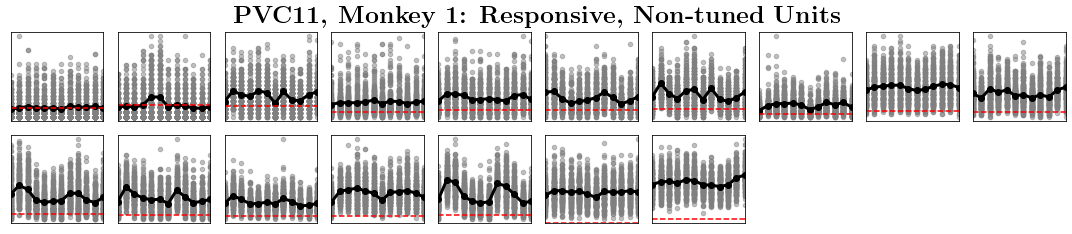

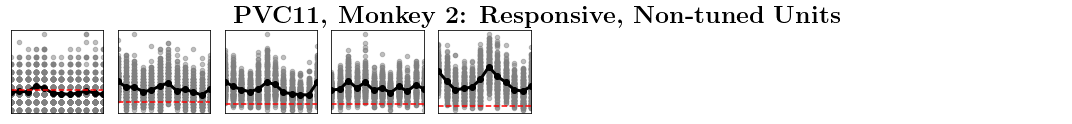

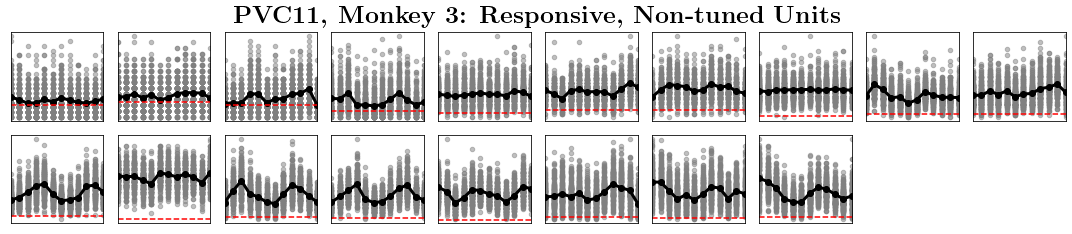

In [10]:
for monkey_idx, (X, units) in enumerate(zip(Xs, responsive_non_tuned_units)):
    fig, axes = plot.plot_tuning_curves(
        X[:, units], stimuli, n_cols=10, include_points=True, use_title=False,
        sort='peak'
    )
    for idx, ax in enumerate(axes.ravel()):
        if idx < units.sum():
            ax.axhline(responsive_threshold, color='r', linestyle='--')

    fig.text(x=0.5, y=1.02, s=r'\textbf{PVC11, Monkey %s: Responsive, Non-tuned Units}' % (monkey_idx + 1),
             va='center', ha='center', fontsize=25)

    plt.tight_layout()
    # plt.savefig('pvc11_monkey%s_responsive_non_tuned.png' %(monkey_idx+1), bbox_inches='tight')
    plt.show()

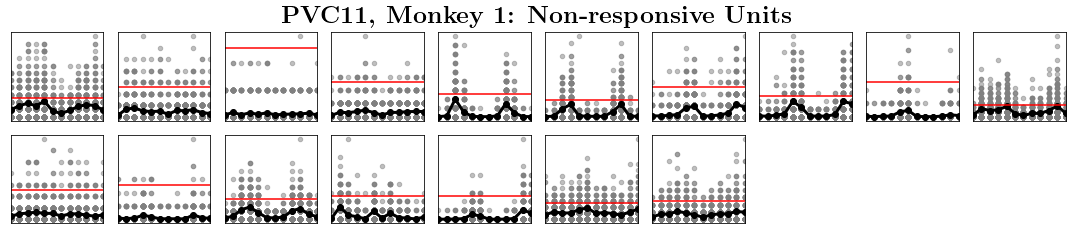

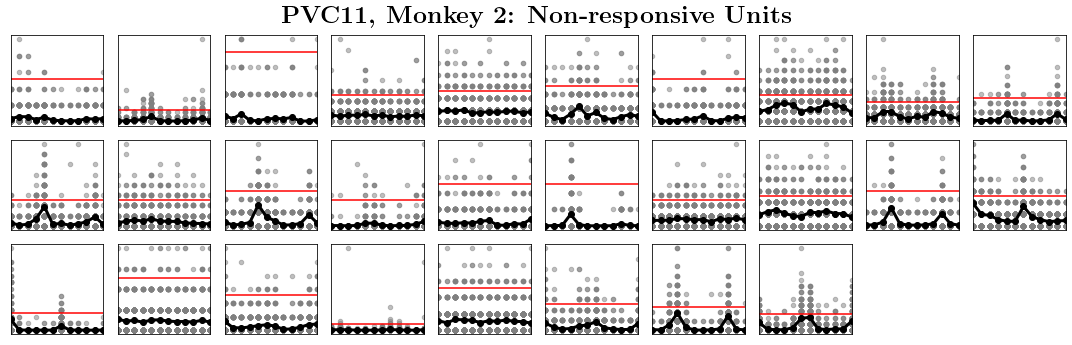

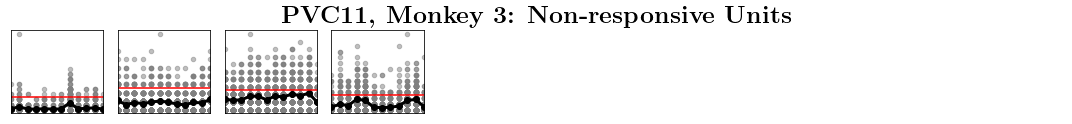

In [11]:
for monkey_idx, (X, units) in enumerate(zip(Xs, non_responsive_units)):
    fig, axes = plot.plot_tuning_curves(
        X[:, units], stimuli,
        n_cols=10, include_points=True, use_title=False
    )
    for idx, ax in enumerate(axes.ravel()):
        if idx < units.sum():
            ax.axhline(responsive_threshold, color='r')

    fig.text(x=0.5, y=1.02, s=r'\textbf{PVC11, Monkey %s: Non-responsive Units}' % (monkey_idx + 1),
             va='center', ha='center', fontsize=25)
    plt.tight_layout()
    # plt.savefig('pvc11_monkey%s_non_responsive.png' %(monkey_idx+1), bbox_inches='tight')
    plt.show()

# Noise correlations

In [12]:
all_corrs = [analysis.all_correlations(Xs[idx], stimuli)
             for idx in range(n_datasets)]
tuned_corrs = [analysis.all_correlations(Xs[idx], stimuli, u1=tuned_units[idx])
               for idx in range(n_datasets)]
responsive_corrs = [analysis.all_correlations(Xs[idx], stimuli, u1=responsive_units[idx])
                    for idx in range(n_datasets)]
responsive_non_tuned_corrs = [analysis.all_correlations(Xs[idx], stimuli, u1=responsive_non_tuned_units[idx])
                              for idx in range(n_datasets)]
non_responsive_corrs = [analysis.all_correlations(Xs[idx], stimuli, u1=non_responsive_units[idx])
                        for idx in range(n_datasets)]

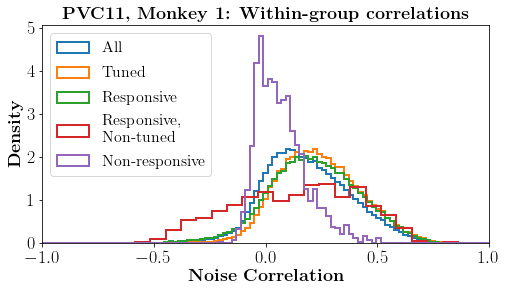

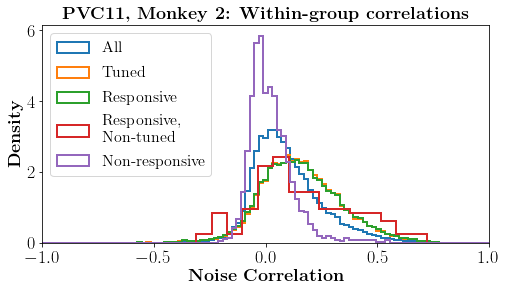

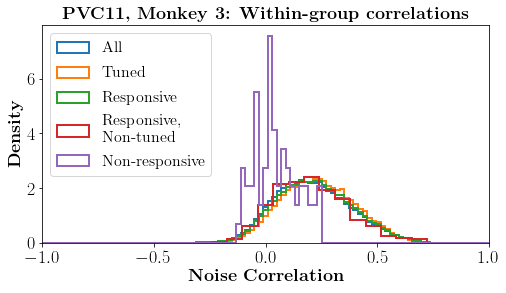

In [13]:
for monkey_idx, (allcorr, tuned, responsive, responsive_non_tuned, non_responsive) in enumerate(
    zip(all_corrs, tuned_corrs, responsive_corrs, responsive_non_tuned_corrs, non_responsive_corrs)
):
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    bins = np.linspace(-1, 1, 100)
    ax.hist(allcorr, bins=bins,
            density=True,
            histtype='step',
            linewidth=2,
            label='All')
    ax.hist(tuned, bins=bins,
            density=True,
            histtype='step',
            linewidth=2,
            label='Tuned')
    ax.hist(responsive, bins=bins,
            density=True,
            histtype='step',
            linewidth=2,
            label='Responsive')
    ax.hist(responsive_non_tuned, bins=np.linspace(-1, 1, 30),
            density=True,
            histtype='step',
            linewidth=2,
            label='Responsive,\nNon-tuned')
    ax.hist(non_responsive, bins=bins,
            density=True,
            histtype='step',
            linewidth=2,
            label='Non-responsive')

    ax.set_xlim([-1, 1])
    ax.set_xticks([-1, -0.5, 0, 0.5, 1])
    ax.tick_params(labelsize=18)
    ax.set_xlabel(r'\textbf{Noise Correlation}', fontsize=18)
    ax.set_ylabel(r'\textbf{Density}', fontsize=18)
    ax.set_title(r'\textbf{PVC11, Monkey %s: Within-group correlations}' % (monkey_idx + 1), fontsize=18)
    plt.legend(loc=2, prop={'size': 16})
    # plt.savefig('pvc11_monkey%s_within_corr.pdf' %(monkey_idx+1), bbox_inches='tight')

    plt.show()

In [14]:
tuned_by_non_tuned_corrs = [
    analysis.all_correlations(Xs[idx], stimuli, u1=tuned_units[idx], u2=~tuned_units[idx])
    for idx in range(n_datasets)
]
tuned_by_responsive_non_tuned_corrs = [
    analysis.all_correlations(Xs[idx], stimuli, u1=tuned_units[idx], u2=responsive_non_tuned_units[idx])
    for idx in range(n_datasets)
]    
responsive_by_non_responsive_corrs = [
    analysis.all_correlations(Xs[idx], stimuli, u1=responsive_units[idx], u2=~responsive_units[idx])
    for idx in range(n_datasets)
]
tuned_by_non_responsive_corrs = [
    analysis.all_correlations(Xs[idx], stimuli, u1=tuned_units[idx], u2=~responsive_units[idx])
    for idx in range(n_datasets)
]

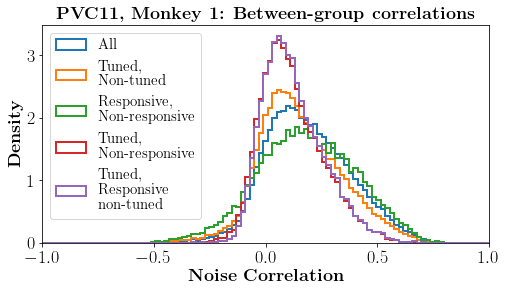

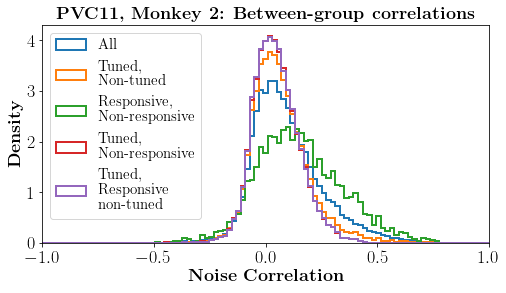

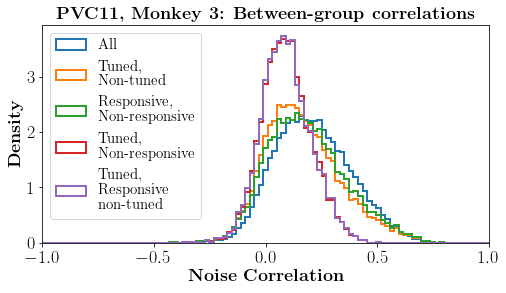

In [15]:
for monkey_idx, (allcorr, tuned_by_non_tuned, responsive_by_non_responsive,
                 tuned_by_non_responsive, tuned_by_responsive_non_tuned) in enumerate(
    zip(all_corrs, tuned_by_non_tuned_corrs, tuned_by_responsive_non_tuned_corrs,
        responsive_by_non_responsive_corrs, tuned_by_non_responsive_corrs)
):
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    bins = np.linspace(-1, 1, 100)
    ax.hist(allcorr, bins=bins,
            density=True,
            histtype='step',
            linewidth=2,
            label='All')
    ax.hist(tuned_by_non_tuned, bins=bins,
            density=True,
            histtype='step',
            linewidth=2,
            label='Tuned,\nNon-tuned')
    ax.hist(responsive_by_non_responsive, bins=bins,
            density=True,
            histtype='step',
            linewidth=2,
            label='Responsive,\nNon-responsive')
    ax.hist(tuned_by_non_responsive, bins=bins,
            density=True,
            histtype='step',
            linewidth=2,
            label='Tuned,\nNon-responsive')
    ax.hist(tuned_by_responsive_non_tuned, bins=bins,
            density=True,
            histtype='step',
            linewidth=2,
            label='Tuned,\nResponsive\nnon-tuned')

    ax.set_xlim([-1, 1])
    ax.set_xticks([-1, -0.5, 0, 0.5, 1])
    ax.tick_params(labelsize=18)
    ax.set_xlabel(r'\textbf{Noise Correlation}', fontsize=18)
    ax.set_ylabel(r'\textbf{Density}', fontsize=18)
    ax.set_title(r'\textbf{PVC11, Monkey %s: Between-group correlations}' % (monkey_idx + 1), fontsize=18)
    plt.legend(loc=2, prop={'size': 15})
    # plt.savefig('pvc11_monkey%s_between_group_noise_correlations.pdf' %(monkey_idx+1), bbox_inches='tight')
    plt.show()